## **ETL Pipeline MELD**

Este flujo de trabajo implementa un pipeline **ETL (Extract, Transform, Load)** diseñado para estructurar la información desordenada del dataset original de **MELD**. Inicialmente, se ingieren y preprocesan los datos para garantizar la integridad y calidad de las muestras que alimentarán los modelos multimodales. Esto facilitará el posterior análisis (EDA) a llevar a cabo.

Los objetivos específicos de este notebook son:

1.  **Extracción e Integridad (Extract):** Carga de los metadatos originales (`train`, `dev`, `test`) y verificación física/lógica de la existencia de cada archivo de vídeo `.mp4` y texto, filtrando aquellas referencias corruptas o inexistentes. También, debido a que **MELD** no presenta los audios por separado sino que se encuentran incluidos en el vídeo (contenedor multimedia), se extraen los audios y se almacenan en un nuevo directorio.
2.  **Transformación y Normalización (Transform):** 
    * Detección y tratamiento de **valores faltantes (NaN)**, **duplicados** (completos e IDs) y ***outliers técnicos*** (errores). 
    * Corrección de rutas de archivos no estándar (especialmente en el conjunto de *test*).
    * **Estandarización** de formatos y codificaciones.
    * **Generación del Target (Variable Objetivo):** Creación de la variable binaria `target_stress` (Estrés vs. No Estrés) mediante el mapeo de las emociones originales (Ira, Miedo) basado en el **Modelo Circumplejo de Russell** (Alta Activación + Valencia Negativa).
3.  **Carga (Load):** Consolidación de los datos limpios en un único archivo (`MELD_clean.csv`) listo para el Análisis Exploratorio (EDA) y el entrenamiento.

Inicialmente, se cargan las librerías y paquetes necesarios para la ejecución de este *notebook*.

In [57]:
!pip install tqdm moviepy==1.0.3 decorator==4.4.2 opencv-python

In [ ]:
import pandas as pd
import os
import numpy as np
import warnings
import html
import re
from tqdm.auto import tqdm 
from moviepy.editor import VideoFileClip
import cv2
import matplotlib.pyplot as plt
import seaborn as sns


# --- CONFIGURACIÓN DE RUTAS ---
DATA_ROOT = "../data"  # Se indica la ruta donde se encuentran todos los datos para el proyecto
RAW_PATH = os.path.join(DATA_ROOT, "RAW", "MELD") # Específicamente, en esta ruta encontramos los datos en crudo ingeridos (descargados) del dataset MELD
PROCESSED_PATH = os.path.join(DATA_ROOT, "PROCESSED") 
FIGURAS_PATH = "../figuras" # Ruta donde se guardarán las figuras generadas en este notebook (y en el resto de notebooks del proyecto)
PROCESSED_AUDIO_PATH = os.path.join(PROCESSED_PATH, "MELD_Audio") # Ruta donde se guardarán los audios extraídos 

---
## **Ingesta y preprocesamiento (transform) en MELD**

####    **1. Extracción (ingesta) de los datos (*CSVs* de *train*, *test* y *dev*) y creación del **DataFrame MELD**. Verificación y corrección de las rutas (función `encontrar_ruta_correcta`):**

In [2]:
# --- PASO 1: INGESTA Y CORRECCIÓN DE RUTAS ---

def encontrar_ruta_correcta(row, folder_name, data_root):
    """
    Normaliza el nombre del archivo de vídeo corrigiendo el error de nombrado en el set de test.
    Devuelve la ruta corta (solo folder_name/nombre_fichero).
    """
    # Nombre estándar: diaX_uttY.mp4
    nombre_estandar = f"dia{row['Dialogue_ID']}_utt{row['Utterance_ID']}.mp4"
    
    # Nombre corrupto (solo ocurre en test): final_videos_testdiaX_uttY.mp4
    nombre_corrupto = f"final_videos_testdia{row['Dialogue_ID']}_utt{row['Utterance_ID']}.mp4"
    
    # Verificamos cuál es el nombre correcto usando la ruta base (portable)
    ruta_verificacion_corrupta = os.path.join(data_root, "RAW", "MELD", folder_name, nombre_corrupto)
    
    if os.path.exists(ruta_verificacion_corrupta):
        return f"{folder_name}/{nombre_corrupto}".replace("\\", "/")
    
    return f"{folder_name}/{nombre_estandar}".replace("\\", "/")


def cargar_split(filename, folder, split_tag, base_csv_path, data_root):
    """
    Carga el csv del split dado, creando un DataFrame añadiendo:
    --> 'split': Nombre del split al que pertenece dicho registro
    --> 'video_path': reconstruye la ruta (nombre del archivo solo para portabilidad) de dicho registro

    Devuelve el DataFrame de dicho split.
    """
    full_path = os.path.join(base_csv_path, filename)
    df = pd.read_csv(full_path)
    df['split'] = split_tag
    # Aplicamos la corrección de ruta
    df['video_path'] = df.apply(lambda row: encontrar_ruta_correcta(row, folder, data_root), axis=1)
    return df

df_train = cargar_split("train_sent_emo.csv", "train_splits", "train",RAW_PATH, DATA_ROOT)
df_dev   = cargar_split("dev_sent_emo.csv", "dev_splits", "dev", RAW_PATH, DATA_ROOT)
df_test  = cargar_split("test_sent_emo.csv", "test_splits", "test", RAW_PATH, DATA_ROOT)

# Unificamos los tres splits en un DataFrame
df_meld = pd.concat([df_train, df_dev, df_test], ignore_index=True)

df_meld.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13708 entries, 0 to 13707
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        13708 non-null  int64 
 1   Utterance     13708 non-null  object
 2   Speaker       13708 non-null  object
 3   Emotion       13708 non-null  object
 4   Sentiment     13708 non-null  object
 5   Dialogue_ID   13708 non-null  int64 
 6   Utterance_ID  13708 non-null  int64 
 7   Season        13708 non-null  int64 
 8   Episode       13708 non-null  int64 
 9   StartTime     13708 non-null  object
 10  EndTime       13708 non-null  object
 11  split         13708 non-null  object
 12  video_path    13708 non-null  object
dtypes: int64(5), object(8)
memory usage: 1.4+ MB



#### **2. Detección de Valores Faltantes (NaN):**

Todas las columnas, incluidas las variables objetivo (`Emotion`, `Sentiment`), las variables predictoras textuales (`Utterance`) y los metadatos de ruta (`video_path`), presentan un recuento de **13708** valores no nulos (*non-null*).

Dado que la totalidad de los registros cuenta con información en todas sus variables, no se requiere aplicar ninguna técnica de eliminación de filas por valores faltantes en esta fase. El dataset **MELD**, en su formato tabular *CSV*, presenta una completitud del **100%**.

#### **3. Detección y tratamiento de duplicados (registros idénticos):**

In [4]:
num_duplicados = df_meld.duplicated().sum()
print(f'Número de registros totalmente idénticos en todos los campos: {num_duplicados}')

Número de registros totalmente idénticos en todos los campos: 0


No hay ningún registro duplicado, cada registro es único (al menos uno de sus campos es distinto).

#### **4. Comprobación de la existencia (integridad) física y acceso (legibilidad) básica de los archivos de vídeo, audio y texto (*Sanity Check*):**


Algo crucial para permitir el posterior análisis y modelado, es comprobar que los datos realmente existen y son accesibles, y tratar adecuadamente aquellos archivos corruptos.

En el caso de **MELD**, se trata de comprobar los ficheros de vídeo (ya que el audio se encuentra incluido en estos, que posteriormente extraeremos) y el campo **Utterance** para el texto.

Para el audio, únicamente se comprobará si el contenedor multimedia (*.mp4*) incluye la pista de audio.

In [5]:
# Configuración inicial
tqdm.pandas()
pd.options.mode.chained_assignment = None  # Silenciamos warnings 
warnings.filterwarnings('ignore') # Ignoramos warnings de PySoundFile

# 1. FUNCIÓN PRINCIPAL:

def validar_integridad_multimodal(path_video, text_utterance):
    """
    Se verifica la integridad física/lógica de archivos de video, la existencia del audio y el texto, 
    además de obtener la duración exacta del vídeo.
    NOTA: la duración del audio = duración del vídeo, ya que también contamos el silencio como parte del audio en sí mismo.
    Retorna False si falla alguna comprobación.
    Args:
        path_video (str): Ruta completa al archivo de vídeo.
        text_utterance (str): El contenido de la transcripción 
    
    Returns:
        (bool, str, float): (True si todo correcto, Mensaje de error si falla, Duración en segundos o 0.0 si error)
    """
    duration = 0.0

    # 1. Validación FÍSICA de VÍDEO (necesaria para poder abrir el archivo)
    # Verificamos que exista y que no sea un archivo vacío (0 bytes)
    if not os.path.exists(path_video) or os.path.getsize(path_video) == 0:
        return False, f"Video no encontrado o corrupto (0 bytes)", duration

    # 2. Validación LÓGICA de VÍDEO 
    # Se intenta abrir el vídeo con OpenCV. Si este está corrupto, se devuelve un error
    try: 
        cap = cv2.VideoCapture(path_video)
        if not cap.isOpened():
            return False, "Video corrupto (No se puede abrir el contenedor)", duration
        
        # Si sí se ha podido abrir, se calcula la duración exacta
        ret,_= cap.read()

        fps = cap.get(cv2.CAP_PROP_FPS) # frames por segundo
        frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT) #número de frames totales
         # Calculamos duración: (Número de frames) / (Frames por segundo)
        if fps > 0: 
            duration = frame_count / fps
        cap.release()
        if not ret:
            return False, "Video corrupto (Stream vacío o ilegible)", duration
        
    except Exception as e:
        return False, f"Error al leer video: {str(e)}", duration
        
    # 3. Validación de AUDIO 
    try :
        # Paso 1. Con MoviePy verificar si hay pista de audio:
        clip = VideoFileClip(path_video)
        contiene_audio = clip.audio is not None

        if not contiene_audio:
            clip.close()
            return False, "Video SIN pista de audio (Mudo)", 0.0
        
        clip.close()
        
    except Exception as e:
        return False, "Error crítico verificando audio", duration

    # 4. Validación de TEXTO (Utterance)
    # Convertimos a string para evitar errores si entra un NaN flotante
    texto = str(text_utterance)
    # Comprobamos que no sea nulo, ni cadena vacía, ni la palabra 'nan' literal
    if not texto or len(texto.strip()) == 0 or texto.lower() == 'nan':
        return False, "Texto vacío o nulo (transcripción faltante)", duration

    return True, "OK", duration



# 2. EJECUCIÓN


# --- VALIDACIÓN ---

# Aplicamos la validación fila a fila
# Esto devuelve una tupla del tipo --->(True/False, Mensaje)
validacion = df_meld.progress_apply(
    lambda x: validar_integridad_multimodal(
        path_video = os.path.join(RAW_PATH, x['video_path']), # Según nuestra estructura de directorios, los archivos de audio/vídeo y texto se encuentran en la ruta RAW/MELD/ + video_path (que ya incluye el folder específico de cada split)
        text_utterance = x['Utterance']), 
    axis=1)
# Separamos el resultado en columnas 'valid_check' para True/False devuelto de la prueba, 'valid_msg' para el mensaje devuelto (ya sea en el caso de error o no), y 'duration' duración exacta del video o 0.0 si error
df_meld['valid_check'] = validacion.apply(lambda x: x[0])
df_meld['valid_msg'] = validacion.apply(lambda x: x[1])
df_meld['duration'] = validacion.apply(lambda x: x[2])
# REPORTE DE ERRORES:
errores = df_meld[~df_meld['valid_check']] #Seleccionamos solo aquellas instancias en las que se ha devuelto un error 

if not errores.empty:
    print(f"Se han encontrado {len(errores)} registros inválidos.")
    print("Distribución de errores:")
    print(errores['valid_msg'].value_counts())
    
    print("\nEjemplos de registros corruptos:")
    print(errores[['Dialogue_ID', 'Utterance_ID', 'valid_msg', 'video_path']].head())

else:
    print("\nTodos los archivos de audio, vídeo y texto son accesibles y válidos.")

  0%|          | 0/13708 [00:00<?, ?it/s]

Se han encontrado 2 registros inválidos.
Distribución de errores:
valid_msg
Video corrupto (No se puede abrir el contenedor)    1
Video no encontrado o corrupto (0 bytes)            1
Name: count, dtype: int64

Ejemplos de registros corruptos:
       Dialogue_ID  Utterance_ID  \
1165           125             3   
11073          110             7   

                                              valid_msg  \
1165   Video corrupto (No se puede abrir el contenedor)   
11073          Video no encontrado o corrupto (0 bytes)   

                         video_path  
1165   train_splits/dia125_utt3.mp4  
11073    dev_splits/dia110_utt7.mp4  


Se indica que todos los vídeos se han recuperado correctamente de los 3 *datasets*, excepto 2 vídeos en los splits de TRAIN y DEV. En el archivo corrupto de **TRAIN** (con `Dialogue_ID` de **125** y `Utterance_ID` de **3**) el error indica que, aunque este archivo exista, no se puede abrir (vídeo corrupto o dañado). Mientras que en el fichero de **DEV** (`Dialogue_ID` de **110** y `Utterance_ID` de **7**), el vídeo directamente o no se ha encontrado o está corrupto, indicando que ha podido ser un error humano de los autores (se les olvidó subir el *.mp4*). Al ser dos únicamente los archivos faltantes de un total de 13708, este error es estadísticamente irrelevante y a continuación se eliminarán.

#### **5. Tratamiento de los archivos corruptos detectados:**

Al ser **2 registros únicamente** corruptos, para su tratamiento hemos optado por eliminarlos.

In [7]:
# ------- TRATAMIENTO DE ERRORES: Eliminar ------------
df_meld = df_meld[df_meld['valid_check']].copy() # Únicamente nos quedamos con aquellos registros en los que no se ha devuelto error
    
# Limpiamos las columnas auxiliares
df_meld.drop(columns=['valid_check', 'valid_msg'], inplace=True)
df_meld.reset_index(drop=True, inplace=True) # Reseteamos el índice tras borrar filas
print(f"Dataset limpio final: {len(df_meld)} registros.")

Dataset limpio final: 13706 registros.


#### **6. Detección y tratamiento de *outliers* (errores técnicos) en relación a la duración del vídeo:**

Gracias a la variable `duration` construida, vamos a detectar y tratar adecuadamente aquellos vídeos que sean más largos de lo normal, y que no sean datos atípicos interesantes, sino **errores de recolección** (en el vídeo se muestra a más de una persona hablando cuando debería ser solo una).

Para el **tratamiento** de estos errores, se opta por eliminarlos, ya que no aportan nada al análisis posterior del *dataset* (EDA) ni al modelado, y su presencia podría introducir ruido innecesario, además de consumir recursos computacionales inútilmente procesando información inválida.

Estadísticas de duración (segundos):
count    13704.000000
mean         3.127065
std          2.413034
min          0.083417
25%          1.543207
50%          2.460790
75%          3.920580
max         41.040968
Name: duration, dtype: float64


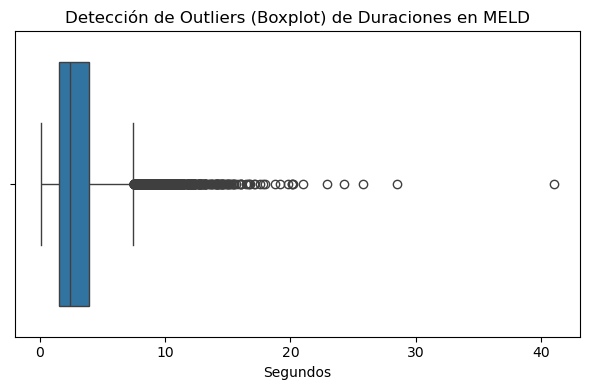

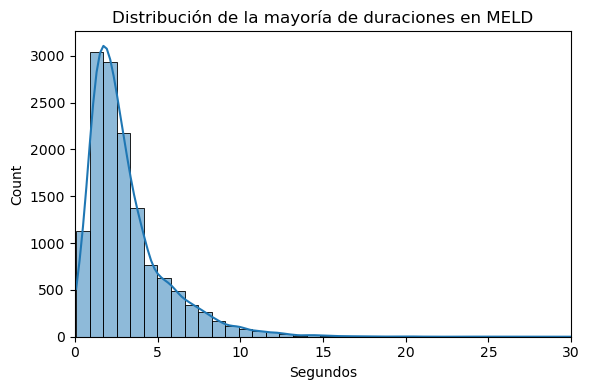

 Top 5 vídeos más largos:
       Dialogue_ID  Utterance_ID  split                     video_path  \
2922           309             0  train   train_splits/dia309_utt0.mp4   
10744           74            19    dev     dev_splits/dia74_utt19.mp4   
4543           485             0  train   train_splits/dia485_utt0.mp4   
7142           757             2  train   train_splits/dia757_utt2.mp4   
3278           344            15  train  train_splits/dia344_utt15.mp4   

        duration  
2922   41.040968  
10744  28.528500  
4543   25.775730  
7142   24.274231  
3278   22.939566  


In [ ]:
# Primero, observamos las estadísticas y una gráfica con la distribución de estas duraciones, y en base a esto decidimos el punto de corte

# Observamos las estadísticas básicas media (mean), máximo (max) y la desviación (std)
stats = df_meld['duration'].describe()
print("Estadísticas de duración (segundos):")
print(stats)


# Gráfico 1: Boxplot (Caja y Bigotes) - Para los outliers lejanos
plt.figure(figsize=(6, 4))
sns.boxplot(x=df_meld['duration'])
plt.title('Detección de Outliers (Boxplot) de Duraciones en MELD')
plt.xlabel('Segundos')

plt.tight_layout()

# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,"Fig_3_2_1_ETL_MELD_OutliersDuracion.png"), dpi=300)

plt.show()

# Gráfico 2: Histograma (Zoom en la zona normal)
plt.figure(figsize=(6, 4))
sns.histplot(df_meld['duration'], bins=50, kde=True)
plt.xlim(0, 30) 
plt.title('Distribución de la mayoría de duraciones en MELD')
plt.xlabel('Segundos')

plt.tight_layout()

# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,"Fig_3_2_2_ETL_MELD_OutliersDuracion.png"), dpi=300)

plt.show()

# Mostramos los 5 vídeos más largos para confirmar que son o no errores
print(" Top 5 vídeos más largos:")
print(df_meld[['Dialogue_ID', 'Utterance_ID', 'split', 'video_path', 'duration']].sort_values(by='duration', ascending=False).head(5))

Se observan, claramente, dos instancias del *split* de **test** con duraciones anómalas que deben ser inspeccionadas y tratadas. Estas son: `dia38_utt4` y `dia220_utt0`. Las duraciones de ambas superan los **200 segundos** (más de **3 minutos**), algo que nos extraña ya que se trata de turnos de palabra donde una única persona está hablando, y la mayoría de los vídeos, como se observa en la gráfica de la derecha, tienen una duración de poco segundos (**media** de **3.16** s). 

Al ser únicamente dos instancias *outliers*, se realiza, manualmente, una inspección visual de estos dos vídeos. En ambos, se observa que no son turnos de palabra, sino son escenas completas donde varios actores interactúan, por tanto son vídeos completos que los autores olvidaron recortar. La categoría emocional asignada a estos registros no nos serviría ya que no sería válida, y por tanto, deben de ser ambos eliminados. 

Establecemos el punto de corte en los **50 segundos**.

* Tratamiento de los *outliers técnicos* estableciendo el punto de corte en base a lo observado:

In [9]:
# PUNTO DE CORTE:

UMBRAL_CORTE = 50.0 # en segundos

# Identificamos los registros que van a ser eliminados (los outliers):
df_eliminados = df_meld[(df_meld['duration'] > UMBRAL_CORTE)]

# Filtramos:
df_meld_clean = df_meld[(df_meld['duration'] <= UMBRAL_CORTE)]

n_eliminados = len(df_meld) - len(df_meld_clean)

if n_eliminados > 0:
    print(f" Número de vídeos eliminados: {n_eliminados}")
    print(df_eliminados[['Dialogue_ID', 'Utterance_ID', 'split', 'duration']].to_string(index=False))
else:
    print("No había archivos fuera del rango establecido")

# Actualizamos el dataframe 
df_meld = df_meld_clean.reset_index(drop=True)

print(f" Dataset limpio con {len(df_meld)} registros.")

 Número de vídeos eliminados: 2
 Dialogue_ID  Utterance_ID split   duration
          38             4  test 304.971097
         220             0  test 235.067984
 Dataset limpio con 13704 registros.


#### **7. Detección de posibles **IDs duplicados**:**

En el punto **3** se determinó la ausencia de registros duplicados completos, pero este punto específico es necesario en el preprocesamiento de los datos, ya que si existieran colisiones en los **IDs** asignados a las instancias, dificultaría el análisis y unificación posterior de ambos corpus.

In [10]:
# Verificamos si hay IDs duplicados
# Usamos Dialogue_ID + Utterance_ID como clave única
ids_duplicados = df_meld.duplicated(subset=['Dialogue_ID', 'Utterance_ID']).sum()
print(f"IDs duplicados (Dialogue_ID + Utterance_ID): {ids_duplicados}")

IDs duplicados (Dialogue_ID + Utterance_ID): 2572


Se ha detectado una **colisión de identificadores** en **2572** pares de registros que comparten la misma clave compuesta (`Dialogue_ID` + `Utterance_ID`).

Esta anomalía es consecuencia de la integración de las tres particiones originales (**train**, **dev**, **test**) en un único DataFrame, dado que los identificadores originales solo garantizan unicidad dentro de cada partición (local), pero no a nivel global del corpus. Para subsanar esta ambigüedad, debe generarse un nuevo identificador único (clave primaria) que incluya la partición de origen. Se descarta el uso del índice implícito (número de fila) como identificador, dado que su volatilidad ante filtrados u ordenamientos comprometería la trazabilidad en la futura fusión con el dataset **IEMOCAP**.

In [11]:
# --- CORRECCIÓN DE IDs: CREACIÓN DE CLAVE PRIMARIA ÚNICA ---

print(f"Duplicados de ID antes de la corrección: {df_meld.duplicated(subset=['Dialogue_ID', 'Utterance_ID']).sum()}")

# 1. Creamos el 'Unique_ID' combinando: Split + Dialogue_ID + Utterance_ID
# Ejemplo resultante: 'train_dia0_utt0'
df_meld['Unique_ID'] = (
    df_meld['split'] + '_' + 
    'dia' + df_meld['Dialogue_ID'].astype(str) + '_' + 
    'utt' + df_meld['Utterance_ID'].astype(str)
)

# 2. Reordenamos columnas para poner el Unique_ID la primera. Esto es para que quede más claro visualmente
cols = ['Unique_ID'] + [c for c in df_meld.columns if c != 'Unique_ID']
df_meld = df_meld[cols]

# 3. Verificación final
duplicados_nuevos = df_meld.duplicated(subset=['Unique_ID']).sum()
print(f"Duplicados de ID tras la corrección (Unique_ID): {duplicados_nuevos}")

if duplicados_nuevos == 0:
    print(df_meld[['Unique_ID', 'Utterance']].head(3))

Duplicados de ID antes de la corrección: 2572
Duplicados de ID tras la corrección (Unique_ID): 0
         Unique_ID                                          Utterance
0  train_dia0_utt0  also I was the point person on my companys tr...
1  train_dia0_utt1                   You mustve had your hands full.
2  train_dia0_utt2                            That I did. That I did.


#### **8. Extracción de los audios en **MELD**:**

En este corpus, los audios se encuentran contenidos en los vídeos, y no por separado. Para facilitar la posterior unificación de ambos datasets (**MELD** e **IEMOCAP**), se extrae el audio incluido en el vídeo, almacenando la ruta del mismo (nombre del archivo) en una nueva variable `audio_path`.

In [ ]:
# --------- Extracción del Audio ------------

# Creamos el directorio destino donde se almacenarán los audios
os.makedirs(PROCESSED_AUDIO_PATH, exist_ok=True)

# 1. Definimos la función que va a extraer el audio del video y lo va almacenar en el directorio
def extract_audio_meld(full_video_path, unique_id, folder, relative_path, output_path):
    """
    Toma la ruta del vídeo (específicamente de la columna llamada 'video_path'), extrae el audio y lo guarda como wav.
    Devuelve la nueva ruta del audio.
    """
    try:
        # Ruta destino (Audio)
        # Nombre del archivo: split_dialogID_utteranceID.wav (para que sea único empleamos Unique_ID ya creada)
        filename = f"{unique_id}.wav"
        save_path = os.path.join(folder, filename)

        # Ruta relativa para guardar en el DataFrame 
        # Corrección de barra invertida (Windows -> Linux) para compatibilidad
        relative_save_path = os.path.join(relative_path, filename).replace("\\", "/")
        
        # Si el archivo ya existe, no lo procesamos de nuevo
        if os.path.exists(save_path):
            return relative_save_path
            
        # Extracción con MoviePy
        video = VideoFileClip(full_video_path)
        if video.audio is not None:
            # Guardamos el audio (logger=None evita que se llene la pantalla de logs)
            video.audio.write_audiofile(save_path, verbose=False, logger=None)
            video.close()
            return os.path.join(output_path, filename)
        else:
            video.close()
            return None # Vídeo mudo
            
    except Exception as e:
        print(f"Error en {unique_id}: {e}")
        return None
    
# 2. Aplicamos la función a cada valor en 'video_path'
tqdm.pandas(desc="Extrayendo audios en MELD")
df_meld['audio_path'] = df_meld.progress_apply(
    lambda row: extract_audio_meld(
        full_video_path=os.path.join(RAW_PATH, row['video_path']),  # Usando DATA_ROOT para mayor portabilidad
        unique_id = row['Unique_ID'],
        folder= PROCESSED_AUDIO_PATH,
        relative_path = PROCESSED_AUDIO_PATH.replace("\\", "/"),
        output_path = "MELD_Audio"
    ), 
    axis=1
)

# 3. Verificamos:
failed_audios = df_meld['audio_path'].isna().sum()
if failed_audios > 0:
    print(f"{failed_audios} clips no tienen audio o dieron error.")
else:
    print("Todos los audios extraídos correctamente.")


Extrayendo audios en MELD:   0%|          | 0/13706 [00:00<?, ?it/s]

Todos los audios extraídos correctamente.


#### **9. Limpieza, normalización del texto y codificaciones:**

La normalización de las transcripciones es un paso crítico, ya que el texto actuará como input directo para el LLM y será base del Análisis Exploratorio de Datos (EDA) posterior. Se procede a la corrección de codificaciones y caracteres corruptos (mojibake) para garantizar la legibilidad.

Además, se implementa una estrategia de validación de calidad (Sanity Check) mediante la generación de metadatos, específicamente el conteo de palabras (`word_count`). Este cálculo permite detectar y filtrar instancias que, tras el preprocesamiento, resulten en cadenas vacías (por ejemplo, *utterances* que originalmente solo contenían puntuación), asegurando así la integridad semántica del dataset antes de su almacenamiento (carga).

In [14]:
# --- LIMPIEZA Y NORMALIZACIÓN DE TEXTO ---

def limpiar_texto(texto):
    """
    Función para corregir caracteres corruptos (mojibake) y decodificar entidades HTML.
    Ejemplo: "company’s" -> "company's"
    """
    if pd.isna(texto):
        return ""
    
    t = str(texto)
    
    # 1. Se decodifican las entidades HTML (por si hay &amp; o &quot;)
    t = html.unescape(t)
    
    # 2. Se corrigen los carácteres de codificación Windows-1252 rotos
    # Se indica explícitamente el código Unicode, para asegurar que independientemente del navegador o editor de código, 
    # el cual puede internamente representar el carácter de forma distinta, asegurar que se corrigen adecuadamente
    t = t.replace('\u0092', "'") # Apóstrofe
    t = t.replace('\u2018', "'")# Comilla simple izq
    t = t.replace('\u2019', "'") # Comilla simple der
    t = t.replace('\u201C', '"') # Comilla doble izq
    t = t.replace('\u201D', '"')  # Comilla doble der
    t = t.replace('\u2026', '...') # Puntos suspensivos
    t = t.replace('\u2013', '-')  # Guión largo
    
    # 3. Eliminar espacios duplicados
    t = re.sub(r'\s+', ' ', t).strip()
    
    return t

# Se aplica la limpieza al campo de Utterance (TEXTO)
df_meld['Utterance'] = df_meld['Utterance'].apply(limpiar_texto)


# 2. Generación de Metadatos de Calidad --> Conteo de Palabras
# Calculamos el número de palabras por Utterance
# Usamos lambda para separar por espacios y contar, creando una nueva variable 'word_count' que almacene el número de palabras por transcripción
df_meld['word_count'] = df_meld['Utterance'].apply(lambda x: len(str(x).split()))

# VERIFICACIÓN DE CALIDAD
# Comprobamos si alguna frase ha quedado vacía (word_count = 0)
vacios = df_meld[df_meld['word_count'] == 0]
if not vacios.empty:
    print(f"Se han detectado {len(vacios)} transcripciones vacías tras la limpieza.")
else:
    print("Todas las transcripciones contienen texto válido.")

# Se aplica la normalización al campo de Emotion
# Pasamos todo a minúsculas y quitamos espacios para evitar duplicados tipo "Neutral " vs "neutral"
df_meld['Emotion'] = df_meld['Emotion'].str.lower().str.strip()

# Limpieza básica también en Speaker:
df_meld['Speaker'] = df_meld['Speaker'].str.strip()

# VERIFICACIÓN
print("Texto limpiado. Ejemplo corregido:")
ejemplo = df_meld[(df_meld['Dialogue_ID'] == 0) & (df_meld['Utterance_ID'] == 0)]['Utterance'].values[0]
print(f"Original corregido: {ejemplo}")

print("\nEmociones normalizadas. Valores únicos encontrados:")
print(df_meld['Emotion'].unique())

Todas las transcripciones contienen texto válido.
Texto limpiado. Ejemplo corregido:
Original corregido: also I was the point person on my company's transition from the KL-5 to GR-6 system.

Emociones normalizadas. Valores únicos encontrados:
['neutral' 'surprise' 'fear' 'sadness' 'joy' 'disgust' 'anger']


#### **10. Generación variable objetivo binaria de Estrés:** 

In [15]:
# --- GENERACIÓN DEL TARGET (ESTRÉS) ---

def etiquetar_estres(emocion):
    """
    Mapeo según Russell (Valence-Arousal).
    Estrés (Clase 1) = Alta Activación + Valencia Negativa
    Control (Clase 0) = El resto
    """
    # Limpieza de texto
    emo = str(emocion).lower().strip()
    
    # Lista de emociones de Alta Activación y Negativas en MELD
    if emo in ['anger', 'fear']: 
        return 1
    else:
        return 0

# Aplicamos la función fila por fila
df_meld['target_stress'] = df_meld['Emotion'].apply(etiquetar_estres)

# --- ANÁLISIS Y VERIFICACIÓN ---
conteo = df_meld['target_stress'].value_counts()
porcentaje = df_meld['target_stress'].mean() * 100

print("Distribución de Clases:")
print(f"Clase 0 (No Estrés): {conteo[0]} muestras")
print(f"Clase 1 (Estrés): {conteo[1]} muestras")
print(f"Porcentaje de Estrés en el dataset: {porcentaje:.2f}%")

Distribución de Clases:
Clase 0 (No Estrés): 11739 muestras
Clase 1 (Estrés): 1965 muestras
Porcentaje de Estrés en el dataset: 14.34%


Podemos observar que con un 14.34% de instancias etiquetadas como Estrés, se trata de un dataset desbalanceado que posteriormente deberemos tratar adecuadamente.

------
## **Carga (Load) en `MELD_clean.csv`**

In [16]:
# --- GUARDADO DEL DATASET PREPROCESADO RESULTANTE---

# Seleccionamos las columnas que nos interesan 
cols_finales = [
    'Dialogue_ID', 
    'Utterance_ID', 
    'Unique_ID', # Identificador único creado debido a las colisiones de Dialogue_ID + Utterance_ID entre splits
    'Utterance',  # Texto
    'Emotion', # Emoción original
    'target_stress', # Nuestro target binario de estrés
    'video_path',     # Ruta relativa al vídeo
    'audio_path',  # Nombre del archivo de audio extraído
    'duration', # Duración exacta del vídeo 
    'Speaker', # Personaje de la serie de 'Friends' que habla en el vídeo
    'split', # Train/Dev/Test
    'word_count'
]

df_clean = df_meld[cols_finales]

#  Definimos ruta de salida para el dataset preprocesado
processed_path = os.path.join(DATA_ROOT, "PROCESSED")

# Creamos el directorio si no existe
os.makedirs(processed_path, exist_ok=True)

# Guardamos nuestro CSV preprocesado
output_file = os.path.join(processed_path, "MELD_clean.csv")
df_clean.to_csv(output_file, index=False)

print(f"Dataset guardado en:{output_file}")
print("Se muestran las primeras 5 filas:")
display(df_clean.head()) 

Dataset guardado en:../Proyecto_TFG_Data\PROCESSED\MELD_clean.csv
Se muestran las primeras 5 filas:


,Dialogue_ID,Utterance_ID,Unique_ID,Utterance,Emotion,target_stress,video_path,audio_path,duration,Speaker,split,word_count
0,0,0,train_dia0_utt0,also I was the point person on my company's tr...,neutral,0,train_splits/dia0_utt0.mp4,MELD_Audio/train_dia0_utt0.wav,5.672333,Chandler,train,16
1,0,1,train_dia0_utt1,You must've had your hands full.,neutral,0,train_splits/dia0_utt1.mp4,MELD_Audio/train_dia0_utt1.wav,1.501500,The Interviewer,train,6
2,0,2,train_dia0_utt2,That I did. That I did.,neutral,0,train_splits/dia0_utt2.mp4,MELD_Audio/train_dia0_utt2.wav,2.919583,Chandler,train,6
3,0,3,train_dia0_utt3,So let's talk a little bit about your duties.,neutral,0,train_splits/dia0_utt3.mp4,MELD_Audio/train_dia0_utt3.wav,2.752750,The Interviewer,train,9
4,0,4,train_dia0_utt4,My duties? All right.,surprise,0,train_splits/dia0_utt4.mp4,MELD_Audio/train_dia0_utt4.wav,6.464792,Chandler,train,4


Hemos decidido **no** incluir la variable de `Sentiment` presente en el dataset original, cuyos valores son:
* **Negative** : se mapean como sentimientos **negativos** las emociones de *ira*, *desprecio*, *miedo* y *tristeza* (en algunos casos también se incluye *sorpresa*).
* **Positive** : se consideran sentimientos **positivos** la emoción de *alegría* y *sorpresa*.
* **Neutral** : para al emoción de *neutral*.

Se ha considerado que este campo resulta **redudante** ante las emociones ya indicadas y etiquetadas por cada registro. Además, la presencia de la variable `Sentiment` podría ensuciar o confundir al modelo si no se usa con cuidado. Por ejemplo, *"Tristeza"* es identificada como **Negative Sentiment**, pero para nosotros es **No Estrés** (baja activación). Si le damos al modelo la pista *Negativo*, podría aprender mal y pensar que la tristeza es estrés, induciendo al modelo a asociaciones espurias, confundiendo valencia negativa con activación fisiológica.

Claramente, otras variables descartadas han sido la de `Season` y `Episode` (número de temporada y capítulo en donde se encuentra dicha escena del vídeo), además de `StartTime` y `EndTime` (*timestamp* de cuándo inicia y finaliza la escena en el episodio).